# Assignment 4 - CISC 351
## News Article Topic Modeling 
### Mike Cruickshank


Dataset contains 12442 news articles from the New York Times and Breitbart News

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [25]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [5]:
data = pd.read_csv('news_altered.csv') #,nrows=11875
# ataset=pd.read_csv("article_dataset.csv",delimiter=",")

In [6]:
print(data.shape)

(12457, 747)


Remove rows with invalid format:

In [7]:
idx = []
for i in range(len(data)):
    if (type(data.iloc[i,9]) != str):
        idx.append(i)

for i in range(len(data)):
    if (type(data.iloc[i,10]) == str):
        idx.append(i)
data = data.drop(labels=idx, axis=0)
col = data.columns
data = data[col[:10]]

In [8]:
print(data.shape)
data.head()


(12415, 10)


,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016,12,NaN,WASHINGTON — Congressional Republicans have...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017,6,NaN,"After the bullet shells get counted, the blood..."
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017,1,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017,4,NaN,"Death may be the great equalizer, but it isn’t..."
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017,1,NaN,"SEOUL, South Korea — North Korea’s leader, ..."


Display the contents of the first two articles:

In [9]:

for i in range (2):
    print('\n\nTitle: %s, Date: %s' % (data.iloc[i,2],data.iloc[i,5]))
    print(data['content'].iloc[i])



Title: House Republicans Fret About Winning Their Health Care Suit - The New York Times, Date: 2016-12-31
WASHINGTON  —   Congressional Republicans have a new fear when it comes to their    health care lawsuit against the Obama administration: They might win. The incoming Trump administration could choose to no longer defend the executive branch against the suit, which challenges the administration’s authority to spend billions of dollars on health insurance subsidies for   and   Americans, handing House Republicans a big victory on    issues. But a sudden loss of the disputed subsidies could conceivably cause the health care program to implode, leaving millions of people without access to health insurance before Republicans have prepared a replacement. That could lead to chaos in the insurance market and spur a political backlash just as Republicans gain full control of the government. To stave off that outcome, Republicans could find themselves in the awkward position of appropriat

### Problem 1: Analysing News Titles 

In [10]:
from gensim import corpora
from gensim.models import LsiModel
from gensim.models import LdaModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel 

from pprint import pprint
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mike\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Function to remove publisher from article title's:

In [12]:
import re
def remove_publisher(title):
    text = []
    for i in title:
        raw = i.lower()
        x = re.split("-", raw)
        if x == None:
            text.append(i)
        else:
            text.append(x[0])
    return text


Stemming of Titles:

In [13]:
def preprocess_data(document):
    tokenizer = RegexpTokenizer('\w+')
    en_stop = set(stopwords.words('english'))
    p_stemmer = PorterStemmer()
    text = []
    count = -1
    for i in document:
        count = count + 1
#         print(count)
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        stopped_tokens = [i for i in tokens if not i in en_stop]
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        text.append(stemmed_tokens)
    return text

<>:2: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \w
<ipython-input-13-4b37c324f7d0>:2: DeprecationWarning: invalid escape sequence \w
  tokenizer = RegexpTokenizer('\w+')


Prepare Corpus:

In [14]:
def prepare_corpus(doc_clean):
    dictionary = corpora.Dictionary(doc_clean)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    return dictionary, doc_term_matrix

Create LDA Model:

In [16]:
def create_gensim_lda_model(doc_clean, number_of_topics, words):
    dictionary, doc_term_matrix = prepare_corpus(doc_clean)
    ldamodel = LdaModel(doc_term_matrix, num_topics = number_of_topics, id2word = dictionary)
#     print(lsamodel.print_topics(num_topics= number_of_topics, num_words=words))
    return ldamodel

Functions to determine optimal number of topics:

In [28]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_top in range(start, stop, step):
#         print(num_top)
        model = LdaModel(doc_term_matrix, num_topics=num_top, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [29]:
def plot_coherence_score(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
#     plt.legend(("coherence_values"), loc='best')
    plt.show()
    return np.argmax(coherence_values)

Determine optimal number of topics for title topic modeling:

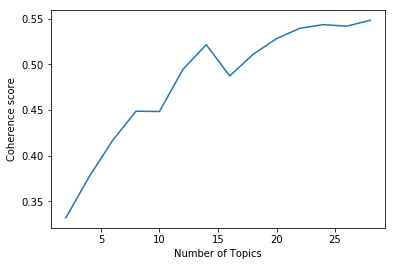

13

In [31]:
start,stop,step=2,30,2
titles = data['title'].values
titles_cleaned = preprocess_data(remove_publisher(titles))
plot_coherence_score(titles_cleaned,start,stop,step)

Build LDA model with optimal number of topics:
* Coherence score peaks at 14

In [58]:
number_of_topics = 14
words = 3
document = remove_publisher(data['title'].values)
titles = preprocess_data(document)
dictionary, doc_term_matrix = prepare_corpus(titles)
# model = create_gensim_lsa_model(titles,number_of_topics,words)
model = create_gensim_lda_model(titles,number_of_topics,words)

Visualize topics and the 10 keywords that best describe them:

In [34]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, doc_term_matrix, dictionary, R=10)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
3     -0.159905 -0.006638       1        1  9.367494
2     -0.177991  0.006057       2        1  8.286426
4     -0.071953 -0.045922       3        1  7.863883
13     0.138863 -0.013462       4        1  7.854697
0      0.097281 -0.227501       5        1  7.550164
1     -0.077682 -0.132440       6        1  7.382765
7      0.048438  0.190837       7        1  7.131313
10    -0.110072  0.044093       8        1  7.070009
11     0.042292 -0.039914       9        1  7.012692
6      0.038396  0.125284      10        1  6.490006
12     0.181704  0.024241      11        1  6.482545
8      0.021038 -0.000153      12        1  5.995766
5      0.050892  0.001659      13        1  5.951884
9     -0.021301  0.073857      14        1  5.560361, topic_info=     Category         Freq       Term        Total  loglift  logprob
65    Default  2495.000000      trump  2495.000000  10.0000  10.0000
1990  Default   190.000000       anti   190.000000   9.0000   9.0000
153   Default   540.000000     donald   540.000000   8.0000   8.0000
1904  Default   191.000000     border   191.000000   7.0000   7.0000
964   Default   167.000000      comey   167.000000   6.0000   6.0000
835   Default   168.000000    hillari   168.000000   5.0000   5.0000
1470  Default   134.000000        cnn   134.000000   4.0000   4.0000
2823  Default   147.000000        gun   147.000000   3.0000   3.0000
967   Default   288.000000      white   288.000000   2.0000   2.0000
833   Default   200.000000    clinton   200.000000   1.0000   1.0000
1228   Topic1    94.776779  christian    95.660454   2.3586  -4.4690
1307   Topic1    57.972595      event    58.755077   2.3545  -4.9605
156    Topic1    47.724312  netanyahu    48.604679   2.3496  -5.1551
1356   Topic1    41.761448    special    42.543938   2.3494  -5.2885
3868   Topic1    38.580032  minnesota    39.362522   2.3478  -5.3678
1720   Topic1    32.678944       fals    33.461430   2.3443  -5.5338
2316   Topic1    29.608812  statement    30.391300   2.3418  -5.6324
1503   Topic1    28.757156     silent    29.539642   2.3411  -5.6616
1917   Topic1    23.517643     declar    24.300129   2.3352  -5.8628
3347   Topic1    23.108524       2018    23.891010   2.3346  -5.8803
2278   Topic1    87.402214      daili    95.312683   2.2813  -4.5500
3195   Topic1    52.245895       host    56.454609   2.2904  -5.0646
967    Topic1   186.388809      white   288.350037   1.9316  -3.7927
6516   Topic1   114.954773  breitbart   164.428757   2.0100  -4.2760
153    Topic1   276.529663     donald   540.314819   1.6981  -3.3982
65     Topic1   634.132141      trump  2495.255371   0.9980  -2.5683
1664   Topic1    89.765472       texa   139.864227   1.9245  -4.5233
3      Topic1   146.638931       hous   359.244385   1.4719  -4.0325
152    Topic1    59.266693      brief    85.381638   2.0028  -4.9385
557    Topic1    71.002365     russia   169.742554   1.4964  -4.7578
...       ...          ...        ...          ...      ...      ...
2396  Topic13    22.126303       wade    22.908758   2.7867  -5.4702
1279  Topic13    21.410358     explos    22.192789   2.7856  -5.5031
3612  Topic13    20.919985        bbc    21.702417   2.7847  -5.5263
4226  Topic13    32.135643      robot    33.382614   2.7834  -5.0970
843   Topic13    51.477337         ad    53.765720   2.7780  -4.6258
2235  Topic13    57.524162   children    61.623482   2.7526  -4.5148
2371  Topic13    40.790680      super    43.147015   2.7653  -4.8585
3407  Topic13    85.360672       fund   104.367119   2.6204  -4.1201
2368  Topic13    36.244442       bowl    38.829910   2.7526  -4.9767
1906  Topic13    41.958241     syrian    49.979973   2.6465  -4.8303
52    Topic13    74.185837      first   214.078339   1.7617  -4.2604
852   Topic13    66.047562    america   190.382095   1.7628  -4.3766
696   Topic13    42.450409     victim    60.080101   2.4741  -4.8186
1843

Print words associated with each topic:

In [63]:
for i,topic in enumerate(model.print_topics(num_topics=14, num_words=10)):
    words = topic[1].split("+")
    print("topic %d: " % i)
    print(words)

topic 0: 
['0.028*"trump" ', ' 0.020*"democrat" ', ' 0.019*"ryan" ', ' 0.016*"paul" ', ' 0.015*"wall" ', ' 0.011*"border" ', ' 0.009*"call" ', ' 0.008*"donald" ', ' 0.008*"miss" ', ' 0.008*"riot"']
topic 1: 
['0.015*"border" ', ' 0.013*"illeg" ', ' 0.012*"suspect" ', ' 0.010*"rape" ', ' 0.010*"patrol" ', ' 0.010*"open" ', ' 0.009*"terror" ', ' 0.008*"arrest" ', ' 0.007*"hit" ', ' 0.007*"former"']
topic 2: 
['0.025*"fake" ', ' 0.024*"media" ', ' 0.022*"news" ', ' 0.012*"refus" ', ' 0.010*"photo" ', ' 0.009*"univers" ', ' 0.009*"social" ', ' 0.009*"head" ', ' 0.008*"davi" ', ' 0.008*"kaepernick"']
topic 3: 
['0.019*"trump" ', ' 0.012*"dem" ', ' 0.012*"islam" ', ' 0.011*"state" ', ' 0.011*"rate" ', ' 0.010*"u" ', ' 0.009*"attack" ', ' 0.009*"american" ', ' 0.008*"texa" ', ' 0.008*"freedom"']
topic 4: 
['0.029*"trump" ', ' 0.015*"california" ', ' 0.015*"bannon" ', ' 0.013*"steve" ', ' 0.012*"fbi" ', ' 0.011*"john" ', ' 0.009*"launch" ', ' 0.009*"event" ', ' 0.007*"chuck" ', ' 0.007*"gov"']

Based on the list above, some possible labels for the topics are:
* Topic 0: Legislative battle to build border wall
* Topic 1: Border wall and illegal immigrants 
* Topic 2: Fake news and the media
* Topic 3: Trump and Islam 
* Topic 4: FBI and US Gov Investigation of Trump
* Topic 5: Trump's Tweeting 
* Topic 6: Trump and Religion 
* Topic 7: CNN/Media and North Korea
* Topic 8: Gun Violence and Gun Control in US
* Topic 9: US Health Care and Obamacare
* Topic 10: FBI (both firing of Director James Comey and the investigation into Hillary Clinton)
* Topic 11: Social Media and Free Speach 
* Topic 12: Terrorism and Immigration 
* Topic 13: Mexico Paying for Boarder Wall and Isreal

Classify random article title by topic number:

In [69]:
idx = randrange(0, 12000, 2)
i = titles[idx]
print(data['title'].iloc[idx])
bow = model.id2word.doc2bow(i) # convert to bag of words format first
doc_topics, word_topics, phi_values = model.get_document_topics(bow, per_word_topics=True)
doc_topics

Donald Trump Could Put Climate Change on Course for ‘Danger Zone’ - The New York Times


[(1, 0.11010579), (5, 0.1805183), (7, 0.124742314), (8, 0.5132046)]

Find article title that best represents each topic:

In [89]:
rep_doc = np.zeros((number_of_topics,2))


for idx in range(len(titles)):
    i = titles[idx]
    bow = model.id2word.doc2bow(i) # convert to bag of words format first
    doc_topics, word_topics, phi_values = model.get_document_topics(bow, per_word_topics=True)

    d1 = [item[0] for item in doc_topics]
    d2 = [item[1] for item in doc_topics]
    max_idx = np.argmax(d2)
    max_val = np.max(d2)
    top_idx = d1[max_idx]
    if rep_doc[top_idx,1] < max_val:
        rep_doc[top_idx,1] = max_val
        rep_doc[top_idx,0] = idx
        

In [93]:
for top in range(number_of_topics):
    i = rep_doc[top,0]
    print('Most representitive title for topic %d is: %s' % (top, data['title'].iloc[int(i)]))

Most representitive title for topic 0 is: Joss Whedon: ’I Want a Rhino to F*ck Paul Ryan to Death’
Most representitive title for topic 1 is: Usain Bolt Stripped of Gold Medal After Relay Teammate Found Guilty of Doping - The New York Times
Most representitive title for topic 2 is: Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial Bias, Dies at 106 - The New York Times
Most representitive title for topic 3 is: Rap Trio Migos Cracks the Code to a No. 1 Hit, One Drop at a Time - The New York Times
Most representitive title for topic 4 is: With National Security Choices, Trump Builds Team to Bulldoze Status Quo - The New York Times
Most representitive title for topic 5 is: U.S. Presidential Race, Colin Powell, Carla Hayden: Your Wednesday Evening Briefing - The New York Times
Most representitive title for topic 6 is: Bill Kristol Backs ’Deep State’ over President Trump, Republican Government - Breitbart
Most representitive title for topic 7 is: U.S. Starts Deploying Thaad Antimissile System in

Build model with only Breitbard articles:

In [35]:
data_breitbart = data[data['publication'] == 'Breitbart']
print(data_breitbart.shape)

(4635, 10)


In [36]:
number_of_topics = 14
words = 3
titles = remove_publisher(data_breitbart['title'].values)
titles_clean = preprocess_data(titles)
dictionary, doc_term_matrix = prepare_corpus(titles_clean)
# model = create_gensim_lsa_model(titles,number_of_topics,words)
model_breitbart = create_gensim_lda_model(titles_clean,number_of_topics,words)

In [37]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model_breitbart, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
10    -0.010440 -0.115089       1        1  8.481807
6     -0.048910  0.021179       2        1  8.044864
13    -0.100876 -0.004306       3        1  8.007158
0     -0.106130 -0.019925       4        1  7.720173
3     -0.099352 -0.057037       5        1  7.542762
7      0.061697  0.043402       6        1  7.024495
5     -0.039956  0.081999       7        1  7.013925
9     -0.004374 -0.005262       8        1  6.981630
8      0.061357  0.003523       9        1  6.970868
2     -0.016222  0.058819      10        1  6.934328
12    -0.015306 -0.103720      11        1  6.891248
1      0.079041  0.159553      12        1  6.513893
4      0.046779  0.062374      13        1  6.034931
11     0.192692 -0.125508      14        1  5.837918, topic_info=     Category        Freq        Term       Total  loglift  logprob
260   Default  138.000000        news  138.000000  30.0000  30.0000
504   Default   69.000000   breitbart   69.000000  29.0000  29.0000
44    Default  158.000000      donald  158.000000  28.0000  28.0000
36    Default  997.000000       trump  997.000000  27.0000  27.0000
302   Default   52.000000      health   52.000000  26.0000  26.0000
180   Default   47.000000         pro   47.000000  25.0000  25.0000
411   Default   78.000000        fake   78.000000  24.0000  24.0000
217   Default   93.000000        plan   93.000000  23.0000  23.0000
787   Default   46.000000         put   46.000000  22.0000  22.0000
89    Default  143.000000        hous  143.000000  21.0000  21.0000
505   Default   40.000000       daili   40.000000  20.0000  20.0000
1152  Default  119.000000       white  119.000000  19.0000  19.0000
716   Default   40.000000        iran   40.000000  18.0000  18.0000
1393  Default  103.000000       first  103.000000  17.0000  17.0000
237   Default   94.000000    obamacar   94.000000  16.0000  16.0000
473   Default   66.000000       islam   66.000000  15.0000  15.0000
338   Default  135.000000       state  135.000000  14.0000  14.0000
146   Default   71.000000      exclus   71.000000  13.0000  13.0000
855   Default   44.000000     hillari   44.000000  12.0000  12.0000
123   Default   74.000000        bill   74.000000  11.0000  11.0000
301   Default   36.000000        care   36.000000  10.0000  10.0000
27    Default   94.000000         new   94.000000   9.0000   9.0000
697   Default   26.000000       child   26.000000   8.0000   8.0000
348   Default   50.000000     inaugur   50.000000   7.0000   7.0000
166   Default   42.000000         job   42.000000   6.0000   6.0000
1121  Default   63.000000     session   63.000000   5.0000   5.0000
353   Default   73.000000  republican   73.000000   4.0000   4.0000
1286  Default   58.000000      muslim   58.000000   3.0000   3.0000
152   Default   81.000000        time   81.000000   2.0000   2.0000
171   Default   97.000000    democrat   97.000000   1.0000   1.0000
...       ...         ...         ...         ...      ...      ...
1232  Topic14   16.662865     nuclear   34.905170   2.1013  -4.8402
900   Topic14   10.640749        talk   18.667645   2.2787  -5.2887
2169  Topic14   10.906480         vow   19.414543   2.2641  -5.2641
864   Topic14   11.746909       carri   22.500278   2.1909  -5.1898
1398  Topic14   13.793513     confirm   30.014568   2.0633  -5.0292
1322  Topic14    5.530887     massacr    7.666269   2.5143  -5.9431
3317  Topic14    8.099067       final   14.051933   2.2898  -5.5617
52    Topic14    8.851313         gov   16.890732   2.1946  -5.4729
475   Topic14   11.918280       refus   28.012131   1.9862  -5.1753
981   Topic14    8.397582         gay   15.792217   2.2092  -5.5255
2672  Topic14   10.495623        week   24.196377   2.0056  -5.3025
1065  Topic14    8.881521   tillerson   18.568050   2.1033  -5.4694
912   Topic14   12.813907       could   39.053345   1.7264  -5.1029
143   Topic14   11.362396        head   31.715889

### Problem 2: Analysing News Articles 

Determine optimal number of topics to use for topic modelling with content of articles:

In [19]:
start,stop,step=2,20,2
document = data['content'].values
doc_cleaned = preprocess_data(document)

2


C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

4


C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

6


C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

8


C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

10


C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

12


C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

14


C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

16


C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

18


C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Mike\Anaconda3\envs\CISC351_Project\lib\site-packages\gensim\models\ldamodel.py:826: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  s

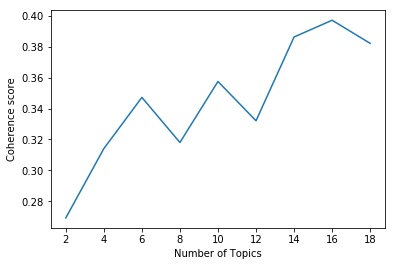

In [20]:
topic_max_coher = plot_coherence_score(doc_cleaned,start,stop,step)

Use LDA with 16 topics:

In [94]:
number_of_topics = 16
words = 3
# document = remove_publisher(data['title'].values)
document = data['content'].values
doc_cleaned = preprocess_data(document)
dictionary, doc_term_matrix = prepare_corpus(doc_cleaned)
# model = create_gensim_lsa_model(titles,number_of_topics,words)
model = create_gensim_lda_model(doc_cleaned,number_of_topics,words)

In [23]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, doc_term_matrix, dictionary, R = 10)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.117051  0.035277       1        1  17.187759
3      0.109644  0.003081       2        1  13.403233
2      0.088155  0.064273       3        1   7.959304
6      0.036963  0.088585       4        1   6.493600
10    -0.092445  0.063528       5        1   6.298890
12     0.016680  0.050886       6        1   6.294313
0      0.071326  0.022826       7        1   6.171893
13     0.016655 -0.099461       8        1   5.056766
4     -0.027410  0.018961       9        1   4.913175
7     -0.011451 -0.094415      10        1   4.442195
15     0.034033  0.003601      11        1   4.319664
14     0.029944 -0.111321      12        1   4.309662
5     -0.084661  0.003285      13        1   4.220941
9     -0.044059 -0.037304      14        1   3.441263
11    -0.026245 -0.045348      15        1   2.939142
1     -0.000078  0.033548      16        1   2.548204, topic_info=      Category          Freq             Term         Total  loglift  logprob
278    Default  43995.000000            trump  43995.000000  10.0000  10.0000
240    Default  64608.000000             said  64608.000000   9.0000   9.0000
2446   Default  10464.000000         democrat  10464.000000   8.0000   8.0000
949    Default  26002.000000           presid  26002.000000   7.0000   7.0000
938    Default   7598.000000            polic   7598.000000   6.0000   6.0000
408    Default   8336.000000           attack   8336.000000   5.0000   5.0000
230    Default   9460.000000       republican   9460.000000   4.0000   4.0000
172    Default  40517.000000               mr  40517.000000   3.0000   3.0000
1376   Default   9334.000000          compani   9334.000000   2.0000   2.0000
4      Default   6404.000000             2017   6404.000000   1.0000   1.0000
61861   Topic1    203.304871             aggi    205.009796   1.7526  -8.5611
38571   Topic1    106.881691            aslan    108.308578   1.7477  -9.2041
25139   Topic1    106.632118        wakefield    108.065926   1.7476  -9.2065
47650   Topic1    110.164742              jie    111.658607   1.7475  -9.1739
34220   Topic1    111.260185             54th    112.857430   1.7467  -9.1640
45080   Topic1    103.172272             1868    104.707123   1.7462  -9.2395
45375   Topic1     88.114876  conservatorship     89.618202   1.7441  -9.3972
9151    Topic1    214.844391             dolc    218.542297   1.7439  -8.5059
43159   Topic1    137.302689            sabin    139.688721   1.7437  -8.9537
38988   Topic1    108.179214            palma    110.059380   1.7437  -9.1921
9159    Topic1    324.302917          gabbana    330.566498   1.7418  -8.0942
21271   Topic1    213.650299           franki    217.941101   1.7411  -8.5115
27512   Topic1    172.626129        streisand    176.946747   1.7363  -8.7247
53128   Topic1    289.455658              elv    300.066101   1.7250  -8.2079
3817    Topic1    368.211609           pillow    400.115204   1.6779  -7.9672
1308    Topic1   1695.909668           artist   2060.339111   1.5663  -6.4399
402     Topic1   1718.144409              art   2288.157715   1.4745  -6.4269
1571    Topic1   1814.675049            music   2480.823730   1.4483  -6.3722
1766    Topic1   1209.411743            album   1615.683472   1.4713  -6.7780
1666    Topic1   1213.538208             song   1675.725708   1.4383  -6.7746
...        ...           ...              ...           ...      ...      ...
66840  Topic16     71.817108  sarahksilverman     74.100105   3.6385  -7.6929
36989  Topic16     51.623756         mcmullen     53.458725   3.6349  -8.0231
67678  Topic16     53.689903           weigel     55.637589   3.6341  -7.9838
22451  Topic16     70.663506          zenimax     74.528748   3.6165  -7.7091
10645  Topic16     44.230442               vr     47.185040   3.6051  -8.1776
20420  Topic16     42.744801            takei     45.822552   3.6003  -8.2118
19887  Topic16     25

Show the ten words that best represent each topic:

In [98]:
for i,topic in enumerate(model.print_topics(num_topics=number_of_topics, num_words=10)):
    words = topic[1].split("+")
    print("topic %d: " % i)
    print(words)

topic 0: 
['0.009*"game" ', ' 0.006*"one" ', ' 0.006*"said" ', ' 0.005*"team" ', ' 0.005*"play" ', ' 0.005*"like" ', ' 0.005*"player" ', ' 0.004*"year" ', ' 0.004*"time" ', ' 0.004*"first"']
topic 1: 
['0.014*"trump" ', ' 0.010*"said" ', ' 0.009*"presid" ', ' 0.008*"republican" ', ' 0.008*"peopl" ', ' 0.008*"hous" ', ' 0.007*"state" ', ' 0.007*"american" ', ' 0.007*"would" ', ' 0.006*"bill"']
topic 2: 
['0.010*"tax" ', ' 0.009*"trump" ', ' 0.008*"american" ', ' 0.007*"state" ', ' 0.007*"said" ', ' 0.007*"year" ', ' 0.006*"u" ', ' 0.006*"unit" ', ' 0.006*"percent" ', ' 0.005*"countri"']
topic 3: 
['0.014*"said" ', ' 0.008*"attack" ', ' 0.008*"polic" ', ' 0.007*"peopl" ', ' 0.005*"report" ', ' 0.005*"one" ', ' 0.005*"kill" ', ' 0.005*"mr" ', ' 0.005*"state" ', ' 0.004*"islam"']
topic 4: 
['0.011*"said" ', ' 0.008*"state" ', ' 0.008*"law" ', ' 0.008*"school" ', ' 0.007*"texa" ', ' 0.006*"student" ', ' 0.006*"case" ', ' 0.005*"report" ', ' 0.005*"feder" ', ' 0.005*"new"']
topic 5: 
['0.006

Find article that best represents each topic:

In [95]:
rep_doc = np.zeros((number_of_topics,2))


for idx in range(len(titles)):
    i = doc_cleaned[idx]
    bow = model.id2word.doc2bow(i) # convert to bag of words format first
    doc_topics, word_topics, phi_values = model.get_document_topics(bow, per_word_topics=True)

    d1 = [item[0] for item in doc_topics]
    d2 = [item[1] for item in doc_topics]
    max_idx = np.argmax(d2)
    max_val = np.max(d2)
    top_idx = d1[max_idx]
    if rep_doc[top_idx,1] < max_val:
        rep_doc[top_idx,1] = max_val
        rep_doc[top_idx,0] = idx
        

In [96]:
for top in range(number_of_topics):
    i = rep_doc[top,0]
    best_doc = data['content'].iloc[int(i)]
    print('Most representitive article for topic %d is: %s...' % (top, best_doc[:100]))

Most representitive article for topic 0 is: OAKLAND, Calif.  —   Kevin Durant began his evening by searching for his teammates. He dribbled agai...
Most representitive article for topic 1 is: WASHINGTON  —   The sudden death of legislation to repeal the Affordable Care Act has created an ope...
Most representitive article for topic 2 is: President Donald Trump on Wednesday proposed deep changes to federal taxes, including sharp cuts in ...
Most representitive article for topic 3 is: ISLAMABAD, Pakistan  —   A suicide bomber struck a hospital in the southwestern Pakistani city of Qu...
Most representitive article for topic 4 is: People living in areas where the Zika virus is circulating should consider delaying pregnancy to avo...
Most representitive article for topic 5 is: Greetings Earthlings! This is your planet and its moon as seen from Mars, some 127 million miles awa...
Most representitive article for topic 6 is: Americans seem very afraid of cancer, with good reason. Unlike other

Determine topic of random article:

In [39]:
from random import randrange

In [41]:
idx = randrange(0, 12000, 2)
i = doc_cleaned[idx]
print(data['content'].iloc[idx])
bow = model.id2word.doc2bow(i) # convert to bag of words format first
doc_topics, word_topics, phi_values = model.get_document_topics(bow, per_word_topics=True)
doc_topics

CHATTANOOGA, Tenn.  —   At least five children were killed on Monday afternoon when a school bus carrying nearly three dozen elementary school students overturned and crashed into a tree in Chattanooga, according to local officials. About two dozen of the 35 Woodmore Elementary School students on the bus were taken to hospitals here after the accident, which occurred before 3:30 p. m. about a mile from the school, Chief Fred Fletcher of the Chattanooga Police Department said on Monday night. The police arrested the bus driver, Johnthony Walker, 24, on Monday night and charged him with five counts of vehicular homicide, as well as reckless endangerment and reckless driving, the police chief said. “Our thoughts, our prayers and all of our efforts are with the families of these children and others impacted by this tragedy,” said Chief Fletcher, who described the accident as a   crash. Information on the conditions of the children who were taken to hospitals was unavailable. An earlier rep

[(0, 0.07194385),
 (1, 0.071401305),
 (2, 0.045813452),
 (3, 0.06779175),
 (4, 0.044354707),
 (5, 0.07277197),
 (6, 0.07850023),
 (7, 0.038276028),
 (8, 0.04866459),
 (9, 0.017665856),
 (10, 0.05025221),
 (11, 0.09954747),
 (12, 0.08850219),
 (13, 0.2045144)]

### Analysing Articles from Specific Data Range:

Topic modeling on articles from week of Trump's inauguration:

In [45]:
data_inag = data[data['date'] > '2017-01-18']
data_inag = data_inag[data_inag['date'] < '2017-01-25']
# data_inag = data[data['date'] == '2017-01-20']

data_inag[['title','author','date','content']].head()

,title,author,date,content
60,Ivanka Trump’s New Washington Home Once Belong...,Julie Hirschfeld Davis,2017-01-23,"WASHINGTON — Ivanka Trump, who is weighing ..."
80,Chase Sapphire Reserve Card’s Huge Bonus Will ...,Ron Lieber,2017-01-23,When a Wall Street banking institution starts ...
101,Farmer on Trial Defends Smuggling Migrants: ‘I...,Adam Nossiter,2017-01-19,"NICE, France — At times it was hard to know..."
130,‘I Thought I Was Impervious to Scams’: Readers...,Hanna Ingber,2017-01-20,Mel Craig’s father has been tormented over ...
215,Fox News Settled Sexual Harassment Allegations...,Emily Steel and Michael S. Schmidt,2017-01-23,In the weeks after Roger Ailes was ousted as t...


In [46]:
number_of_topics = 8
words = 3
document = remove_publisher(data_inag['title'].values)
# document = data_inag['content'].values
doc_cleaned_inag = preprocess_data(document)
dictionary_inag, doc_term_matrix_inag = prepare_corpus(doc_cleaned_inag)
# model = create_gensim_lsa_model(titles,number_of_topics,words)
model_inag = create_gensim_lda_model(doc_cleaned_inag,number_of_topics,words)

In [47]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model_inag, doc_term_matrix_inag, dictionary_inag, R=10)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.062655  0.095213       1        1  15.978165
2     -0.025278 -0.126968       2        1  14.124688
5      0.066344 -0.032194       3        1  14.095567
3      0.056713 -0.036803       4        1  12.615763
1      0.019675  0.054813       5        1  11.664150
4     -0.115407  0.013067       6        1  11.553310
6      0.029367 -0.011586       7        1  10.646906
0     -0.094069  0.044458       8        1   9.321456, topic_info=     Category       Freq         Term      Total  loglift  logprob
268   Default  18.000000      inaugur  18.000000  10.0000  10.0000
189   Default  15.000000       donald  15.000000   9.0000   9.0000
6     Default  67.000000        trump  67.000000   8.0000   8.0000
61    Default   4.000000         live   4.000000   7.0000   7.0000
80    Default  10.000000       presid  10.000000   6.0000   6.0000
949   Default   5.000000       border   5.000000   5.0000   5.0000
685   Default   5.000000      hillari   5.000000   4.0000   4.0000
42    Default   6.000000       report   6.000000   3.0000   3.0000
956   Default   6.000000         anti   6.000000   2.0000   2.0000
1157  Default   3.000000        media   3.000000   1.0000   1.0000
112    Topic1   2.133295        thing   2.677706   1.6067  -5.1879
341    Topic1   2.133261        chapo   2.677703   1.6066  -5.1879
329    Topic1   1.450637       energi   1.994969   1.5153  -5.5735
432    Topic1   1.450623        sworn   1.994966   1.5153  -5.5735
344    Topic1   1.450618     extradit   1.994967   1.5153  -5.5735
440    Topic1   1.450610   prosecutor   1.994966   1.5153  -5.5735
108    Topic1   1.450559         hell   1.994962   1.5153  -5.5736
124    Topic1   1.450534       climat   1.994958   1.5153  -5.5736
345    Topic1   1.450464      kingpin   1.994951   1.5152  -5.5736
779    Topic1   1.450392          rio   1.994945   1.5152  -5.5737
343    Topic1   2.133154           el   3.277267   1.4045  -5.1879
189    Topic1   5.546731       donald  15.767207   0.7892  -4.2323
141    Topic1   4.181386            u  10.817076   0.8835  -4.5149
6      Topic1  11.480465        trump  67.502762   0.0624  -3.5049
80     Topic1   3.498592       presid  10.755632   0.7109  -4.6932
346    Topic1   2.133315      mexican   5.234003   0.9364  -5.1878
527    Topic1   2.133449        women   5.950529   0.8082  -5.1878
572    Topic1   2.133208        first   7.129524   0.6273  -5.1879
268    Topic1   2.816140      inaugur  18.674150  -0.0578  -4.9102
449    Topic2   1.392646         mark   1.940423   1.6255  -5.4910
...       ...        ...          ...        ...      ...      ...
238    Topic7   1.873335         bomb   4.966978   1.2648  -4.9118
38     Topic7   1.273954         show   3.063538   1.3625  -5.2974
32     Topic7   1.273875          fox   3.101555   1.3501  -5.2975
6      Topic7   7.270216        trump  67.502762   0.0115  -3.5558
824    Topic7   1.873451         milo   6.134604   1.0537  -4.9118
80     Topic7   2.473040       presid  10.755632   0.7699  -4.6341
268    Topic7   2.473167      inaugur  18.674150   0.2183  -4.6341
100    Topic7   1.274057        white   7.448672   0.4741  -5.2974
75     Topic7   1.274050          lie   4.925128   0.8878  -5.2974
141    Topic7   1.274023            u  10.817076   0.1010  -5.2974
1175   Topic8   1.191866          boy   1.751477   1.9879  -5.2311
156    Topic8   1.191842       asylum   1.751480   1.9879  -5.2311
622    Topic8   1.191840        boost   1.751480   1.9879  -5.2311
72     Topic8   1.191669          big   1.751503   1.9877  -5.2313
1141   Topic8   0.631029        carri   1.190480   1.7381  -5.8670
1305   Topic8   0.631028         fast   1.190480   1.7381  -5.8670
1143   Topic8   0.631024  defenseless   1.190480   1.7381  -5.8670
826    Topic8   0.631024       raonic   1.190480   1.7381  -5.8670
1144   Topic8   0.631022       demand   1.190481   1.7381  -5.8670


Topic modeling on article titles from month of Brexit referendum:

In [48]:
data_brexit = data[data['date'] > '2016-06-10']
data_brexit = data_brexit[data_brexit['date'] < '2016-06-30']
# data_inag = data[data['date'] == '2017-01-20']

data_brexit[['title','author','date','content']].head()

,title,author,date,content
2646,"Justices Lean Toward Bob McDonnell, Ex-Virgini...",Adam Liptak,2016-06-28,WASHINGTON — The Supreme Court on Wednesday...
2685,Takata Airbag Recall Is Said to Grow by 35 Mil...,Hiroko Tabuchi,2016-06-14,Regulators are expected to announce as early a...
2687,Washington Metro System Failed to Learn From A...,Nicholas Fandos,2016-06-15,WASHINGTON — The capital region’s subway sy...
2690,Obama May Create Monument to Gay Rights Moveme...,Michael D. Shear,2016-06-26,WASHINGTON — The White House is considering...
2731,"Amazon Proves Infertile Soil for Unions, So Fa...",Nick Wingfield,2016-06-20,"SEATTLE — In early April, Kellen Wadach, th..."


In [55]:
number_of_topics = 14
words = 3
document = remove_publisher(data_brexit['title'].values)
# document = data_brexit['content'].values
doc_cleaned_brexit = preprocess_data(document)
dictionary_brexit, doc_term_matrix_brexit = prepare_corpus(doc_cleaned_brexit)
# model = create_gensim_lsa_model(titles,number_of_topics,words)
model_brexit = create_gensim_lda_model(doc_cleaned_brexit,number_of_topics,words)

In [56]:
pyLDAvis.enable_notebook()

In [57]:
vis = pyLDAvis.gensim.prepare(model_brexit, doc_term_matrix_brexit, dictionary_brexit, R=10)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.136481 -0.020229       1        1  11.412913
7      0.079052 -0.138617       2        1   9.231473
9     -0.090208  0.007834       3        1   9.095272
11    -0.114556 -0.005337       4        1   8.522047
12    -0.052903 -0.006259       5        1   7.885413
13     0.039928  0.138502       6        1   7.138297
2     -0.037399  0.029280       7        1   6.581885
1     -0.008131 -0.043078       8        1   6.256978
4      0.071028  0.118244       9        1   6.240672
10     0.085197 -0.059398      10        1   6.179879
0     -0.019895 -0.011736      11        1   5.585360
6      0.087953  0.010785      12        1   5.331906
3      0.074415 -0.017254      13        1   5.331318
5      0.021999 -0.002737      14        1   5.206588, topic_info=     Category       Freq          Term      Total  loglift  logprob
53    Default  34.000000         trump  34.000000  10.0000  10.0000
49    Default  30.000000        donald  30.000000   9.0000   9.0000
47    Default  13.000000       clinton  13.000000   8.0000   8.0000
50    Default  13.000000       hillari  13.000000   7.0000   7.0000
54    Default  12.000000        brexit  12.000000   6.0000   6.0000
179   Default  16.000000       orlando  16.000000   5.0000   5.0000
224   Default   5.000000             c   5.000000   4.0000   4.0000
297   Default  10.000000         brief  10.000000   3.0000   3.0000
145   Default  12.000000             u  12.000000   2.0000   2.0000
234   Default  10.000000           say  10.000000   1.0000   1.0000
733    Topic1   1.541302             2   2.113111   1.8549  -5.0419
161    Topic1   1.541302           big   2.113111   1.8549  -5.0419
479    Topic1   1.541302           let   2.113111   1.8549  -5.0419
697    Topic1   0.797225          fall   1.369035   1.6297  -5.7011
699    Topic1   0.797225          june   1.369034   1.6297  -5.7011
480    Topic1   0.797225          look   1.369035   1.6297  -5.7011
951    Topic1   0.797225           rip   1.369034   1.6297  -5.7011
952    Topic1   0.797225         trade   1.369034   1.6297  -5.7011
782    Topic1   0.797225       neutral   1.369034   1.6297  -5.7011
700    Topic1   0.797225           sap   1.369035   1.6297  -5.7011
950    Topic1   0.797225      confront   1.369035   1.6297  -5.7011
481    Topic1   0.797225          mean   1.369035   1.6297  -5.7011
185    Topic1   1.541303        sander   2.720717   1.6022  -5.0419
181    Topic1   1.541302         berni   2.720717   1.6022  -5.0419
1162   Topic1   0.797225        resort   1.369035   1.6297  -5.7011
701    Topic1   0.797225         sharp   1.369035   1.6297  -5.7011
583    Topic1   0.797225      european   1.369034   1.6297  -5.7011
734    Topic1   0.797225        declar   1.369034   1.6297  -5.7011
542    Topic1   0.797225         doubt   1.369035   1.6297  -5.7011
543    Topic1   0.797225         futur   1.369035   1.6297  -5.7011
...       ...        ...           ...        ...      ...      ...
204   Topic13   0.619943         photo   1.203571   2.2682  -5.1915
163   Topic13   0.619944             e   5.155801   0.8133  -5.1915
226   Topic13   0.619944             f   3.137358   1.3101  -5.1915
640   Topic14   1.158484         civil   1.743494   2.5465  -4.5426
406   Topic14   1.158484          long   1.743494   2.5465  -4.5426
3     Topic14   1.158484          lean   1.743495   2.5465  -4.5426
5     Topic14   1.158484        toward   1.743494   2.5465  -4.5426
787   Topic14   0.599216           fee   1.184226   2.2740  -5.2018
864   Topic14   0.599216        worker   1.184226   2.2740  -5.2018
133   Topic14   0.599216         fault   1.184226   2.2740  -5.2018
134   Topic14   0.599216        polici   1.184226   2.2740  -5.2018
267   Topic14   0.599216  psychologist   1.184226   2.2740  -5.2018
269   Topic14   0.599216       testifi   1.184226   2.2740  -5.2018
863   Topic14   0.599216         

In [101]:
for i,topic in enumerate(model_brexit.print_topics(num_topics=14, num_words=6)):
    words = topic[1].split("+")
    print("topic %d: " % i)
    print(words)

topic 0: 
['0.015*"trump" ', ' 0.015*"donald" ', ' 0.015*"new" ', ' 0.010*"clinton" ', ' 0.010*"hillari" ', ' 0.010*"attack"']
topic 1: 
['0.014*"trump" ', ' 0.014*"donald" ', ' 0.013*"orlando" ', ' 0.010*"suprem" ', ' 0.010*"law" ', ' 0.010*"fund"']
topic 2: 
['0.022*"u" ', ' 0.013*"orlando" ', ' 0.009*"brief" ', ' 0.009*"even" ', ' 0.009*"donald" ', ' 0.009*"trump"']
topic 3: 
['0.021*"c" ', ' 0.016*"leav" ', ' 0.011*"orlando" ', ' 0.011*"shoot" ', ' 0.011*"attack" ', ' 0.011*"armi"']
topic 4: 
['0.010*"get" ', ' 0.010*"kill" ', ' 0.010*"treat" ', ' 0.005*"even" ', ' 0.005*"brief" ', ' 0.005*"say"']
topic 5: 
['0.011*"say" ', ' 0.011*"senat" ', ' 0.011*"court" ', ' 0.011*"long" ', ' 0.011*"civil" ', ' 0.011*"lean"']
topic 6: 
['0.016*"say" ', ' 0.011*"market" ', ' 0.011*"804" ', ' 0.011*"american" ', ' 0.011*"egyptair" ', ' 0.011*"two"']
topic 7: 
['0.026*"orlando" ', ' 0.011*"say" ', ' 0.011*"polic" ', ' 0.011*"u" ', ' 0.008*"gun" ', ' 0.007*"brexit"']
topic 8: 
['0.038*"trump" ', '

Find article title that best represents each topic:

In [108]:
rep_doc = np.zeros((number_of_topics,2))


for idx in range(len(doc_cleaned_brexit)):
    i = doc_cleaned_brexit[idx]
    bow = model_brexit.id2word.doc2bow(i) # convert to bag of words format first
    doc_topics, word_topics, phi_values = model_brexit.get_document_topics(bow, per_word_topics=True)

    d1 = [item[0] for item in doc_topics]
    d2 = [item[1] for item in doc_topics]
    max_idx = np.argmax(d2)
    max_val = np.max(d2)
    top_idx = d1[max_idx]
    if rep_doc[top_idx,1] < max_val:
        rep_doc[top_idx,1] = max_val
        rep_doc[top_idx,0] = idx
        

In [109]:
for top in range(number_of_topics):
    i = rep_doc[top,0]
    print('Most representitive title for topic %d is: %s' % (top, data_brexit['title'].iloc[int(i)]))

Most representitive title for topic 0 is: Supreme Court Turns Away Challenge to Connecticut Ban on Semiautomatic Weapons - The New York Times
Most representitive title for topic 1 is: Spurred by Orlando Shooting, G.O.P. Senator Offers a Gun Control Compromise - The New York Times
Most representitive title for topic 2 is: Dustin Johnson Wins U.S. Open at Oakmont for First Major Title - The New York Times
Most representitive title for topic 3 is: Cable Industry Mobilizes Lobbying Army to Block F.C.C. Moves - The New York Times
Most representitive title for topic 4 is: 5 Get Life Sentences in India for Rape of Danish Woman in 2014 - The New York Times
Most representitive title for topic 5 is: Mississippi Ends Inquiry Into 1964 Killing of 3 Civil Rights Workers - The New York Times
Most representitive title for topic 6 is: Sepp Blatter and Deputies Arranged Huge Payouts After Indictments, FIFA Says - The New York Times
Most representitive title for topic 7 is: Game 7 of N.B.A. Finals Draws